# Download Mgnify analysis results

![MGnify](../assets/figs/mgnify_banner.png)

1. search studies
2. get analyses in a dataframe and save them as `.parquet`
3. compare to local data

In [1]:
import os
from jsonapi_client import Session as APISession

# Dataframes and display
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data transformation
from functools import reduce

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline 

# Warning verbosity
import warnings 
warnings.filterwarnings(action="ignore")

import logging
logging.disable(logging.CRITICAL)

/home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/.venv/lib/python3.12/site-packages/jsonapi_client/__init__.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Taxonomy summaries from MGnify studies

In [2]:
TAXONOMY_RANKS = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# For metadata download
analysisId = 'MGYS00006680'

# local predownloaded MGnify file
ds = {'Sola': ['MGYS00006680', 'mgnify_data/SRP237882_taxonomy_abundances_SSU_v5.0.tsv'],}

OUT_FOLDER = os.path.abspath(analysisId)
ANALYSIS_CACHE = os.path.abspath('analysis_cache')

if not os.path.exists(OUT_FOLDER):
    os.makedirs(OUT_FOLDER)
else:
    print(f"Directory {analysisId} already exists.")

if not os.path.exists(ANALYSIS_CACHE):
    os.makedirs(ANALYSIS_CACHE)
else:
    print(f"Directory {ANALYSIS_CACHE} already exists.")

Directory MGYS00006680 already exists.
Directory /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/analysis_cache already exists.


In [3]:
# Data download, and save to file
from urllib.request import urlretrieve
import sys
from pathlib import Path
from datetime import datetime

from momics.taxonomy import (
    clean_tax_row,
    fill_taxonomy_placeholders,
    remove_high_taxa,
    prevalence_cutoff,
    normalize_abundance,
    rarefy_table,
)
from momics.utils import load_and_clean

from momics.metadata import (
    process_collection_date,
    extract_season,
)
from tqdm import tqdm

from mgnify_methods.taxonomy import (
    aggregate_by_taxonomic_level,
    fill_lower_taxa,
    pivot_taxonomic_data,
    invert_pivot_taxonomic_data,
    prevalence_cutoff_abund,
)
from mgnify_methods.utils.plot import (
    plot_rarefaction_mgnify,
    plot_season_reads_hist,
    save_plot_with_metadata,
)
from mgnify_methods.metacomp.rarefaction import rarefaction_curve

from mgnify_methods.utils.io import fetch_analysis_metadata

### Get all samples from the study
- Query MGnify for metadata purposes

In [7]:
try:
    # analysis_meta = pd.read_csv(f'{analysisId}_analysis_meta.csv').reset_index(drop=True)

    analysis_meta_dfs = {}
    for k, values in ds.items():
        analysisId = values[0]
        analysis_meta = fetch_analysis_metadata(ANALYSIS_CACHE, analysisId)

        analysis_meta_dfs[k] = analysis_meta

    # add study tag to each analysis metadata dataframe
    for k, df in analysis_meta_dfs.items():
        print(f"Analysis {k} has {df.shape[0]} samples.")
        df['study_tag'] = k

    # concatenate all metadata dataframes
    analysis_meta = pd.concat(analysis_meta_dfs.values(), ignore_index=True)
    analysis_meta.set_index('relationships.run.data.id', inplace=True)
except FileNotFoundError:
    print(f"Metadata file not found: Downloading...")

    with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as session:
        analysis_meta = map(lambda r: r.json, session.iterate(f'studies/{analysisId}/analyses'))
        analysis_meta = pd.json_normalize(analysis_meta)

    analysis_meta.to_csv(f'{analysisId}_analysis_meta.csv', index=False)

Analysis Sola has 283 samples.


In [8]:
analysis_meta.head(1)

,type,id,attributes.accession,attributes.pipeline-version,attributes.experiment-type,attributes.analysis-status,attributes.analysis-summary,attributes.is-private,attributes.last-update,attributes.complete-time,attributes.instrument-platform,attributes.instrument-model,relationships.study.data.id,relationships.study.data.type,relationships.run.data.type,relationships.sample.data.id,relationships.sample.data.type,study_tag
relationships.run.data.id,,,,,,,,,,,,,,,,,,
SRR10717050,analysis-jobs,MGYA00776407,MGYA00776407,5.0,amplicon,completed,"[{'key': 'Submitted nucleotide sequences', 'value': '20364'}, {'key': 'Nucleotide sequences after format-specific filtering', 'value': '17715'}, {'key': 'Nucleotide sequences after length filtering', 'value': '17715'}, {'key': 'Nucleotide sequences after undetermined bases filtering', 'value': '17715'}, {'key': 'Predicted LSU sequences', 'value': '0'}, {'key': 'Predicted SSU sequences', 'value': '12400'}]",False,2024-07-29T08:09:22.442354,2024-07-29T08:09:00,ILLUMINA,Illumina MiSeq,MGYS00006680,studies,runs,SRS5841512,samples,Sola


In [9]:
try:
    samples_meta = pd.read_csv(os.path.join(ANALYSIS_CACHE, f'{analysisId}_samples_meta.csv')).reset_index(drop=True)
except FileNotFoundError:
    samples_meta = mgm.utils.api.get_mgnify_metadata(analysisId)
    samples_meta.to_csv(os.path.join(ANALYSIS_CACHE, f'{analysisId}_samples_meta.csv'), index=False)

In [10]:
# enhance metadata
samples_meta.rename(columns={'collection date': 'collection_date'}, inplace=True)
samples_meta, cols = process_collection_date(samples_meta)
samples_meta, cols = extract_season(samples_meta)

samples_meta['sample_type'] = samples_meta['sample-name'].apply(lambda x: 'prok' if 'Pro' in x else 'euk')
samples_meta.head()

,id,latitude,biosample,longitude,accession,sample-desc,sample-name,sample-alias,last-update,geographic location (longitude),"geographic location (country and/or sea,region)",collection_date,environmental package,geographic location (latitude),study,year,month,month_name,day,season,sample_type
0,SRS5841737,42.48,SAMN13327036,3.14,SRS5841737,Metagenome or environmental sample from seawater metagenome,S100Euk_CGCTCT-BNV7B,S100Euk_CGCTCT-BNV7B,2024-07-29T09:17:14,3.14,France: Mediterranean sea: North West,2016-07-25,Metagenome or environmental,42.48,MGYS00006680,2016,7,Jul,25,Summer,euk
1,SRS5841734,42.48,SAMN13327035,3.14,SRS5841734,Metagenome or environmental sample from seawater metagenome,S99Euk_ACGATC-BNV7B,S99Euk_ACGATC-BNV7B,2024-07-29T09:17:00,3.14,France: Mediterranean sea: North West,2016-07-18,Metagenome or environmental,42.48,MGYS00006680,2016,7,Jul,18,Summer,euk
2,SRS5841731,42.48,SAMN13327033,3.14,SRS5841731,Metagenome or environmental sample from seawater metagenome,S97Euk_CTACTA-BNV7B,S97Euk_CTACTA-BNV7B,2024-07-29T09:16:46,3.14,France: Mediterranean sea: North West,2016-06-20,Metagenome or environmental,42.48,MGYS00006680,2016,6,Jun,20,Spring,euk
3,SRS5841733,42.48,SAMN13327030,3.14,SRS5841733,Metagenome or environmental sample from seawater metagenome,S94Euk_AAAGCG-BNV7B,S94Euk_AAAGCG-BNV7B,2024-07-29T09:16:33,3.14,France: Mediterranean sea: North West,2016-05-23,Metagenome or environmental,42.48,MGYS00006680,2016,5,May,23,Spring,euk
4,SRS5841726,42.48,SAMN13327027,3.14,SRS5841726,Metagenome or environmental sample from seawater metagenome,S91Euk_TTACTC-BNV7B,S91Euk_TTACTC-BNV7B,2024-07-29T09:16:19,3.14,France: Mediterranean sea: North West,2016-04-25,Metagenome or environmental,42.48,MGYS00006680,2016,4,Apr,25,Spring,euk


In [11]:
samples_meta[samples_meta['collection_date'] == '2016-07-25']
# samples_meta[samples_meta['collection_date'] == pd.to_datetime('2016-07-25')]
# samples_meta[samples_meta['collection_date'] == datetime(2016, 7, 25)]
# samples_meta[samples_meta['collection_date'] == pd.Timestamp("2016-07-25")]

,id,latitude,biosample,longitude,accession,sample-desc,sample-name,sample-alias,last-update,geographic location (longitude),"geographic location (country and/or sea,region)",collection_date,environmental package,geographic location (latitude),study,year,month,month_name,day,season,sample_type
0,SRS5841737,42.48,SAMN13327036,3.14,SRS5841737,Metagenome or environmental sample from seawater metagenome,S100Euk_CGCTCT-BNV7B,S100Euk_CGCTCT-BNV7B,2024-07-29T09:17:14,3.14,France: Mediterranean sea: North West,2016-07-25,Metagenome or environmental,42.48,MGYS00006680,2016,7,Jul,25,Summer,euk
46,SRS5841616,42.48,SAMN13327183,3.14,SRS5841616,Metagenome or environmental sample from seawater metagenome,S100Pro_TAAGGG-BFCG2,S100Pro_TAAGGG-BFCG2,2024-07-29T09:06:12,3.14,France: Mediterranean sea: North West,2016-07-25,Metagenome or environmental,42.48,MGYS00006680,2016,7,Jul,25,Summer,prok


### Stats on reads identified

Samples not matched to season metadata: 0
Saved PNG: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/season_reads_unfiltered_20260107_114353.png
Saved PDF: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/season_reads_unfiltered_20260107_114353.pdf
Metadata saved: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/season_reads_unfiltered_20260107_114353_metadata.json
Description saved: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/season_reads_unfiltered_20260107_114353_description.txt


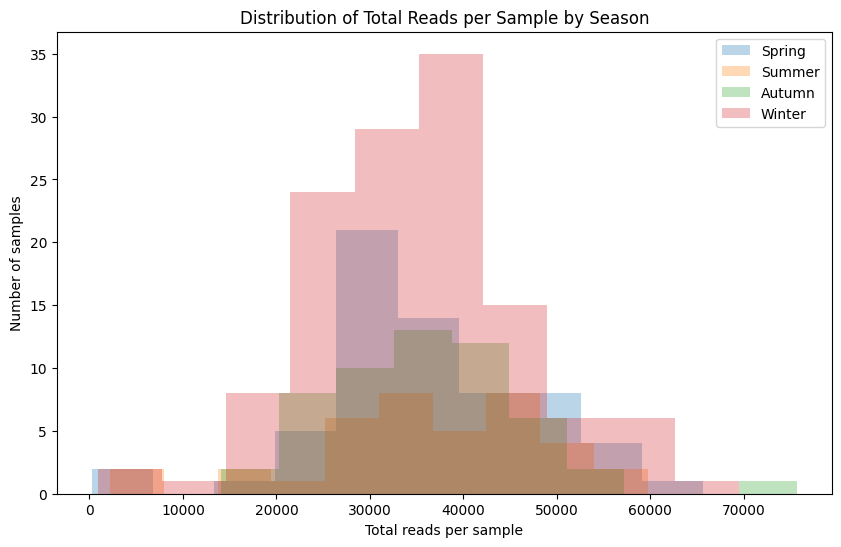

In [13]:
total_dict = plot_season_reads_hist(
    analysis_meta,
    samples_meta,
    name='season_reads_unfiltered.png',
    out_dir=OUT_FOLDER,
)

### Filter out samples with little reads

In [14]:
cutoff = 25000

to_drop = []
for season, v in total_dict.items():
    for sample, (total, ratio) in v.items():
        if total > cutoff:
            continue
        to_drop.append(sample)
print(f"Dropping {len(to_drop)} samples with less than {cutoff} reads: {to_drop}")

for sample in to_drop:
    analysis_meta = analysis_meta[analysis_meta.index!=sample]

Dropping 43 samples with less than 25000 reads: ['SRR10717023', 'SRR10716954', 'SRR10716950', 'SRR10716948', 'SRR10717010', 'SRR10717002', 'SRR10716879', 'SRR10717005', 'SRR10716938', 'SRR10716996', 'SRR10716995', 'SRR10716991', 'SRR10716988', 'SRR10716990', 'SRR10716985', 'SRR10716989', 'SRR10716933', 'SRR10716928', 'SRR10716869', 'SRR10717050', 'SRR10717069', 'SRR10717046', 'SRR10716986', 'SRR10716977', 'SRR10716972', 'SRR10716971', 'SRR10716970', 'SRR10716910', 'SRR10716860', 'SRR10717103', 'SRR10717070', 'SRR10716983', 'SRR10716979', 'SRR10716974', 'SRR10716969', 'SRR10716966', 'SRR10716963', 'SRR10716962', 'SRR10716916', 'SRR10716915', 'SRR10716902', 'SRR10716900', 'SRR10716871']


Samples not matched to season metadata: 0
Saved PNG: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/season_reads_filtered_20260107_114402.png
Saved PDF: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/season_reads_filtered_20260107_114402.pdf
Metadata saved: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/season_reads_filtered_20260107_114402_metadata.json
Description saved: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/season_reads_filtered_20260107_114402_description.txt


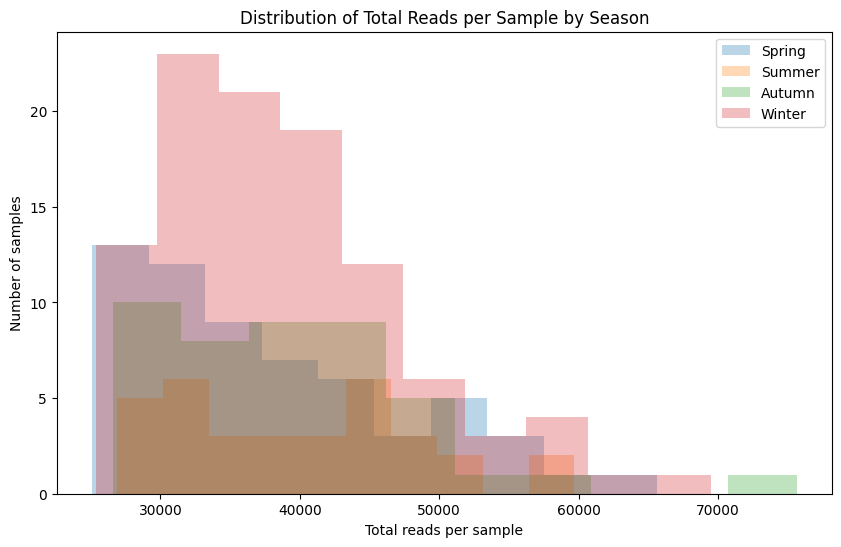

In [15]:
total_dict = plot_season_reads_hist(
    analysis_meta,
    samples_meta,
    name='season_reads_filtered.png',
    out_dir=OUT_FOLDER,
)

### Load the Mgnify summary table
- This should be concatenation of all the samples from above

In [16]:
root_folder = os.path.abspath(os.path.join('../'))
data_folder = os.path.join(root_folder, 'data')

In [17]:
df_tax_summary = pd.read_csv(os.path.join(data_folder, ds['Sola'][1]), sep='\t')

df_tax_summary.rename(columns={'#SampleID': 'taxonomy'}, inplace=True)
df_tax_summary.set_index('taxonomy', inplace=True)
# df_tax_summary.head()

In [18]:
# filter according to analysis_meta, which has been filtered to certain number of reads
print('Number of samples before filtering:', df_tax_summary.shape[1])
for col in df_tax_summary.columns:
    if col not in analysis_meta.index:
        df_tax_summary.drop(columns=[col], inplace=True)
print('Number of samples after filtering:', df_tax_summary.shape[1])

Number of samples before filtering: 283
Number of samples after filtering: 240


In [19]:
# assertions to ensure data integrity
assert len(df_tax_summary[df_tax_summary.index=='sk__Archaea']) == 1, f"There should be exactly one row with Archea, but found {len(df_tax_summary[df_tax_summary.index=='sk__Archea'])}"
assert len(df_tax_summary[df_tax_summary.index=='sk__Eukaryota']) == 1, f"There should be exactly one row with Eukaryota, but found {len(df_tax_summary[df_tax_summary.index=='sk__Eukaryota'])}"

# asserts to ensure data integrity
assert analysis_meta['relationships.sample.data.id'].size == len(df_tax_summary.columns)
lst1 = analysis_meta.index.tolist()
lst2 = df_tax_summary.columns.tolist()
lst1.sort(), lst2.sort()
assert lst1 == lst2

del lst1, lst2

These are the total number of reads annotated

In [20]:
abundance_sums = df_tax_summary.iloc[:,:].apply(sum, axis=0)
# abundance_sums.head()

In [21]:
df_tax_summary.head()

,SRR10716830,SRR10716840,SRR10716850,SRR10716870,SRR10716880,SRR10716890,SRR10716920,SRR10716930,SRR10716940,SRR10716960,SRR10716980,SRR10717000,SRR10717020,SRR10717030,SRR10717040,SRR10717060,SRR10717080,SRR10717090,SRR10717100,SRR10716821,SRR10716831,SRR10716841,SRR10716851,SRR10716861,SRR10716881,SRR10716891,SRR10716901,SRR10716911,SRR10716921,SRR10716931,SRR10716941,SRR10716951,SRR10716961,SRR10716981,SRR10717001,SRR10717011,SRR10717021,SRR10717031,SRR10717041,SRR10717051,SRR10717061,SRR10717071,SRR10717081,SRR10717091,SRR10717101,SRR10716822,SRR10716832,SRR10716842,SRR10716852,SRR10716862,SRR10716872,SRR10716882,SRR10716892,SRR10716912,SRR10716922,SRR10716932,SRR10716942,SRR10716952,SRR10716982,SRR10716992,SRR10717012,SRR10717022,SRR10717032,SRR10717042,SRR10717052,SRR10717062,SRR10717072,SRR10717082,SRR10717092,SRR10717102,SRR10716823,SRR10716833,SRR10716843,SRR10716853,SRR10716863,SRR10716873,SRR10716883,SRR10716893,SRR10716903,SRR10716913,SRR10716923,SRR10716943,SRR10716953,SRR10716973,SRR10716993,SRR10717003,SRR10717013,SRR10717033,SRR10717043,SRR10717053,SRR10717063,SRR10717073,SRR10717083,SRR10717093,SRR10716824,SRR10716834,SRR10716844,SRR10716854,SRR10716864,SRR10716874,SRR10716884,SRR10716894,SRR10716904,SRR10716914,SRR10716924,SRR10716934,SRR10716944,SRR10716964,SRR10716984,SRR10716994,SRR10717004,SRR10717014,SRR10717024,SRR10717034,SRR10717044,SRR10717054,SRR10717064,SRR10717074,SRR10717084,SRR10717094,SRR10716825,SRR10716835,SRR10716845,SRR10716855,SRR10716865,SRR10716875,SRR10716885,SRR10716895,SRR10716905,SRR10716925,SRR10716935,SRR10716945,SRR10716955,SRR10716965,SRR10716975,SRR10717015,SRR10717025,SRR10717035,SRR10717045,SRR10717055,SRR10717065,SRR10717075,SRR10717085,SRR10717095,SRR10716826,SRR10716836,SRR10716846,SRR10716856,SRR10716866,SRR10716876,SRR10716886,SRR10716896,SRR10716906,SRR10716926,SRR10716936,SRR10716946,SRR10716956,SRR10716976,SRR10717006,SRR10717016,SRR10717026,SRR10717036,SRR10717056,SRR10717066,SRR10717076,SRR10717086,SRR10717096,SRR10716827,SRR10716837,SRR10716847,SRR10716857,SRR10716867,SRR10716877,SRR10716887,SRR10716897,SRR10716907,SRR10716917,SRR10716927,SRR10716937,SRR10716947,SRR10716957,SRR10716967,SRR10716987,SRR10716997,SRR10717007,SRR10717017,SRR10717027,SRR10717037,SRR10717047,SRR10717057,SRR10717067,SRR10717077,SRR10717087,SRR10717097,SRR10716828,SRR10716838,SRR10716848,SRR10716858,SRR10716868,SRR10716878,SRR10716888,SRR10716898,SRR10716908,SRR10716918,SRR10716958,SRR10716968,SRR10716978,SRR10716998,SRR10717008,SRR10717018,SRR10717028,SRR10717038,SRR10717048,SRR10717058,SRR10717068,SRR10717078,SRR10717088,SRR10717098,SRR10716829,SRR10716839,SRR10716849,SRR10716859,SRR10716889,SRR10716899,SRR10716909,SRR10716919,SRR10716929,SRR10716939,SRR10716949,SRR10716959,SRR10716999,SRR10717009,SRR10717019,SRR10717029,SRR10717039,SRR10717049,SRR10717059,SRR10717079,SRR10717089,SRR10717099
taxonomy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sk__Archaea,0,0,0,0,0,0,0,16,2,4,7,2,0,1,2,0,0,0,0,0,0,0,0,0,0,0,6,9,3,0,1,1,2,13,3,0,1,0,13,8,0,0,0,0,0,0,0,0,0,0,0,0,0,13,7,8,0,2,0,0,2,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,10,3,0,4,4,4,2,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,7,0,0,3,12,0,1,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,9,0,2,1,0,6,2,5,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,3,2,1,0,3,1,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,18,4,1,8,7,0,3,1,0,2,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,3,1,3,0,1,1,2,2,7,0,0,0,0,0,0,0,0,0,0,2,0,5,24,5,0,6,4,0,0,26,3,2,0,0,0,0
sk__Archaea;k__;p__Candidatus_Aenigmarchaeota,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [22]:
long_df = invert_pivot_taxonomic_data(df_tax_summary, target_col=['taxonomy'])
long_df.head()

,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
source material ID,,,,,,,,,
SRR10716830,139,Eukaryota,None,None,None,None,None,None,None
SRR10716830,625,Eukaryota,,,,Jakobida,None,None,None
SRR10716830,1,Eukaryota,,,,Pirsoniales,None,None,None
SRR10716830,2,Eukaryota,,,,Pirsoniales,,Pirsonia,None
SRR10716830,50,Eukaryota,,,,Telonemida,,Telonema,None


In [23]:
long_df.index

Index(['SRR10716830', 'SRR10716830', 'SRR10716830', 'SRR10716830',
       'SRR10716830', 'SRR10716830', 'SRR10716830', 'SRR10716830',
       'SRR10716830', 'SRR10716830',
       ...
       'SRR10717099', 'SRR10717099', 'SRR10717099', 'SRR10717099',
       'SRR10717099', 'SRR10717099', 'SRR10717099', 'SRR10717099',
       'SRR10717099', 'SRR10717099'],
      dtype='object', name='source material ID', length=70657)

In [24]:
# this fails and should be reported to the EBI MGnify team
# for sample in analysis_meta['relationships.run.data.id'].to_list():
#     lst = analysis_meta[analysis_meta['relationships.run.data.id']==sample]['attributes.analysis-summary'].values[0]
#     df_tmp = pd.DataFrame(lst)
#     assert (long_df[long_df['sample']==sample]['abundance'].sum() == 
#             int(df_tmp[df_tmp['key']=='Predicted SSU sequences']['value'].values[0])), f"Sum mismatch for sample {sample}, {df1.tail(2)}, \
#     {long_df[long_df['sample']==sample]['abundance'].sum()} \
#     {abundance_sums[sample]}"


# this is just an internal check, external one is above and failing
for sample in analysis_meta.index.to_list():
    assert long_df[long_df.index==sample]['abundance'].sum() == df_tax_summary[sample].sum()

In [25]:
# Fill lower taxa with None
long_df = fill_lower_taxa(long_df, TAXONOMY_RANKS)

# Placeholders for missing taxa to be able to map on certain taxon and to be able to rarefy
long_df = fill_taxonomy_placeholders(long_df, TAXONOMY_RANKS)

### Starting point is `long_df`

In [26]:
# IMPORTANT: removing high taxa is basically running `aggregate_by_taxonomic_level` with dropna option
if not long_df.index.name == 'source material ID':
    try:
        long_df_indexed = long_df.set_index('source material ID')
    except Exception as e:
        print(f"Error setting index: {e}")

else:
    long_df_indexed = long_df

### Rarefaction per taxon level

Prevalence cutoff at 0.01% (max threshold 4.538600000000001): reduced from (101, 133) to (77, 133)
Minimum rarefaction depth: 17341
Prevalence cutoff at 0.01% (max threshold 4.538600000000001): reduced from (266, 133) to (177, 133)
Minimum rarefaction depth: 17333
Prevalence cutoff at 0.01% (max threshold 4.538600000000001): reduced from (694, 133) to (400, 133)
Minimum rarefaction depth: 17314
Prevalence cutoff at 0.01% (max threshold 4.538600000000001): reduced from (1230, 133) to (621, 133)
Minimum rarefaction depth: 17290
Prevalence cutoff at 0.01% (max threshold 4.538600000000001): reduced from (1707, 133) to (832, 133)
Minimum rarefaction depth: 17271
Minimum depth after rarefaction: 17271
Minimum rarefaction depth: 17271
Plotting rarefaction for phylum, shape (77, 133) samples
Minimum rarefaction depth: 17271
Plotting rarefaction for class, shape (177, 133) samples
Minimum rarefaction depth: 17271
Plotting rarefaction for order, shape (400, 133) samples
Minimum rarefaction depth

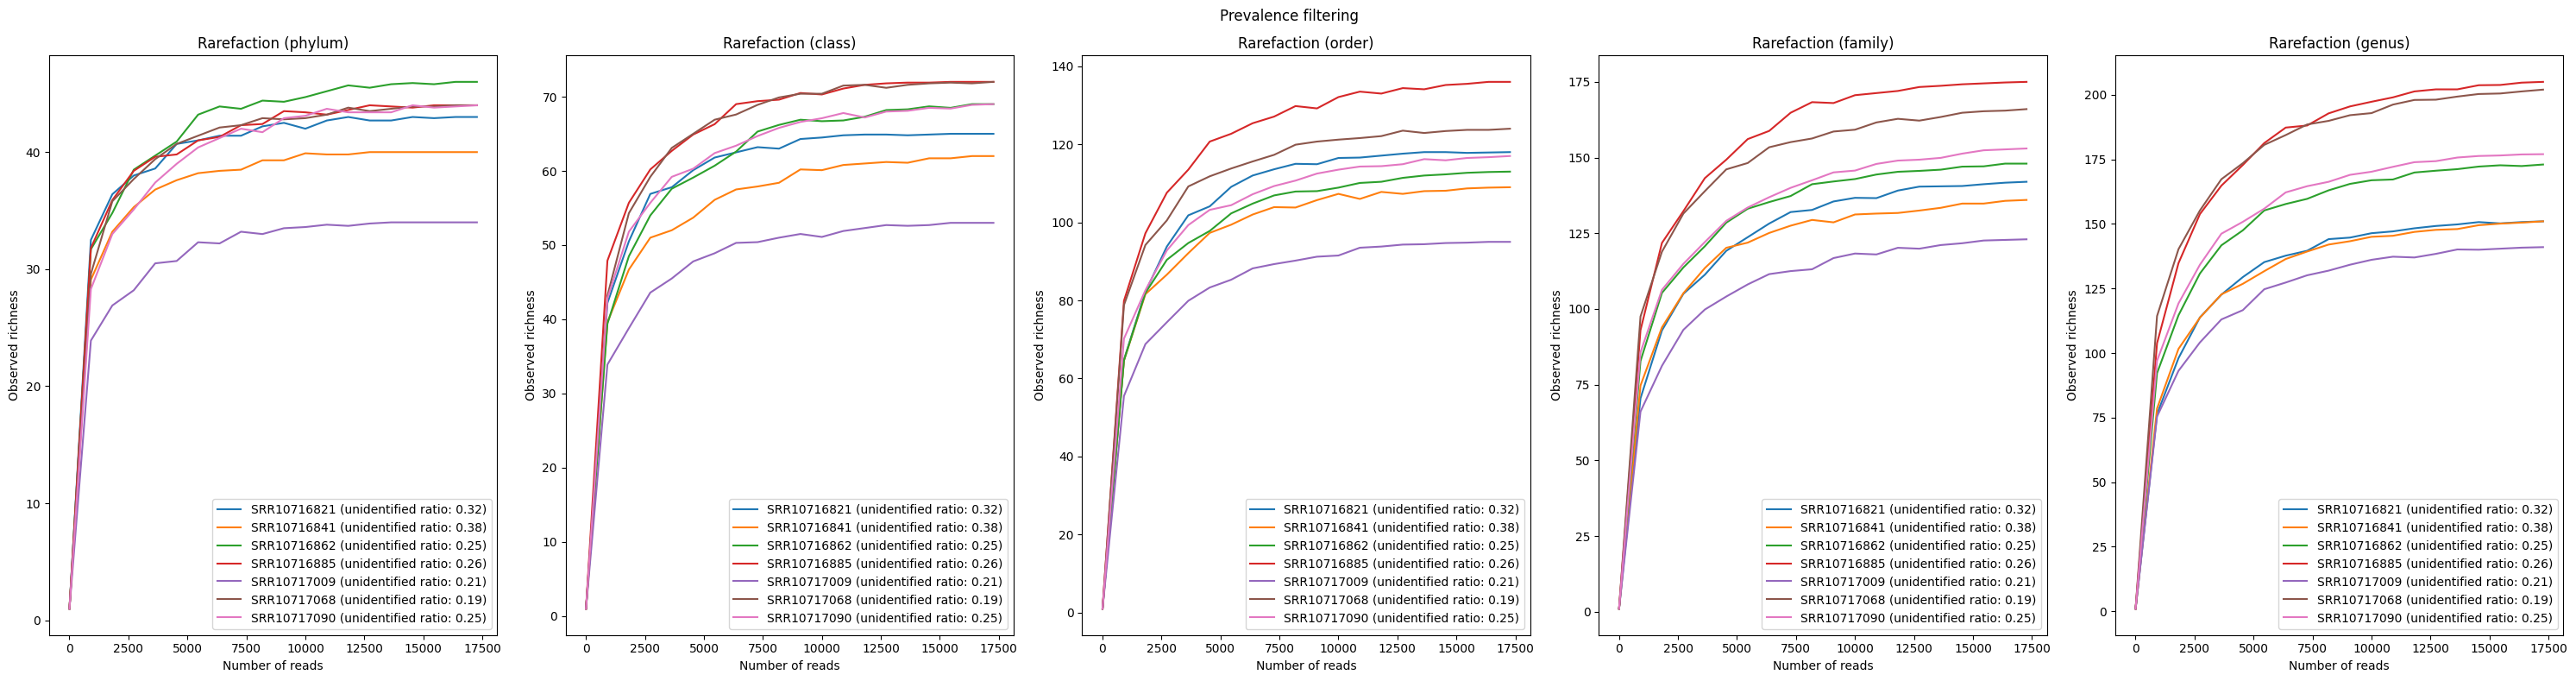

In [27]:
## EUKARYOTES ##
sample_list = samples_meta[samples_meta['sample_type']=='euk']['id'].tolist()  # this is sample list
# data_list = analysis_meta[analysis_meta['relationships.sample.data.id'].isin(sample_list)]['relationships.run.data.id'].tolist()

data_list = analysis_meta[analysis_meta['relationships.sample.data.id'].isin(sample_list)].index.tolist()

# in this case it is correct, aggregate 
dropna = False   # setting for aggregation
tax_levels = ['phylum', 'class', 'order', 'family', 'genus']

# filter long_df_indexed to keep only eukaryotic samples
long_df_filt_inp = long_df_indexed[long_df_indexed.index.isin(data_list)]


min_depth = 1e9
# first pass to determine min depth
for tax in tax_levels:
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=dropna)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back

    #prevalence filtering
    df_filt_pivot = prevalence_cutoff_abund(df_filt_pivot, percent=0.01, skip_columns=0)
    df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
    min_depth = min(min_depth, df_filt_pivot.sum().min())

print("Minimum depth after rarefaction:", min_depth)

# now run again with fixed depth
fig, axes = plt.subplots(1, len(tax_levels), figsize=(6 * len(tax_levels), 8))
rarefied_tables = {}
rarefied_tables['euk'] = {}
for ax, tax in zip(axes, tax_levels):
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=dropna)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back

    #prevalence filtering
    df_filt_pivot = prevalence_cutoff_abund(
        df_filt_pivot,
        percent=0.01,
        skip_columns=0,
        verbose=False,
    )
    df_filt_pivot = rarefy_table(df_filt_pivot, depth=min_depth)
    rarefied_tables['euk'][tax] = df_filt_pivot

    # rarefaction
    print(f"Plotting rarefaction for {tax}, shape {df_filt_pivot.shape} samples")
    plot_rarefaction_mgnify(
        df_filt_pivot,
        analysis_meta,
        every_nth=20,
        ax=ax,
        title=f'Rarefaction ({tax})',
    )

plt.suptitle("Prevalence filtering")
plt.tight_layout()

# save_plot_with_metadata(
#     fig,
#     filename='rarefaction_euk.png',
#     description='Rarefaction curves per taxonomic level',
#     out_dir=OUT_FOLDER,
# )

Prevalence cutoff at 0.01% (max threshold 5.1432): reduced from (122, 107) to (63, 107)
Minimum rarefaction depth: 14634
Prevalence cutoff at 0.01% (max threshold 5.1432): reduced from (227, 107) to (124, 107)
Minimum rarefaction depth: 14628
Prevalence cutoff at 0.01% (max threshold 5.1432): reduced from (405, 107) to (217, 107)
Minimum rarefaction depth: 14622
Prevalence cutoff at 0.01% (max threshold 5.1432): reduced from (704, 107) to (388, 107)
Minimum rarefaction depth: 14601
Prevalence cutoff at 0.01% (max threshold 5.1432): reduced from (1415, 107) to (628, 107)
Minimum rarefaction depth: 14587
Minimum depth after rarefaction: 14587
Minimum rarefaction depth: 14587
Plotting rarefaction for phylum, shape (63, 107) samples
Minimum rarefaction depth: 14587
Plotting rarefaction for class, shape (124, 107) samples
Minimum rarefaction depth: 14587
Plotting rarefaction for order, shape (217, 107) samples
Minimum rarefaction depth: 14587
Plotting rarefaction for family, shape (388, 107

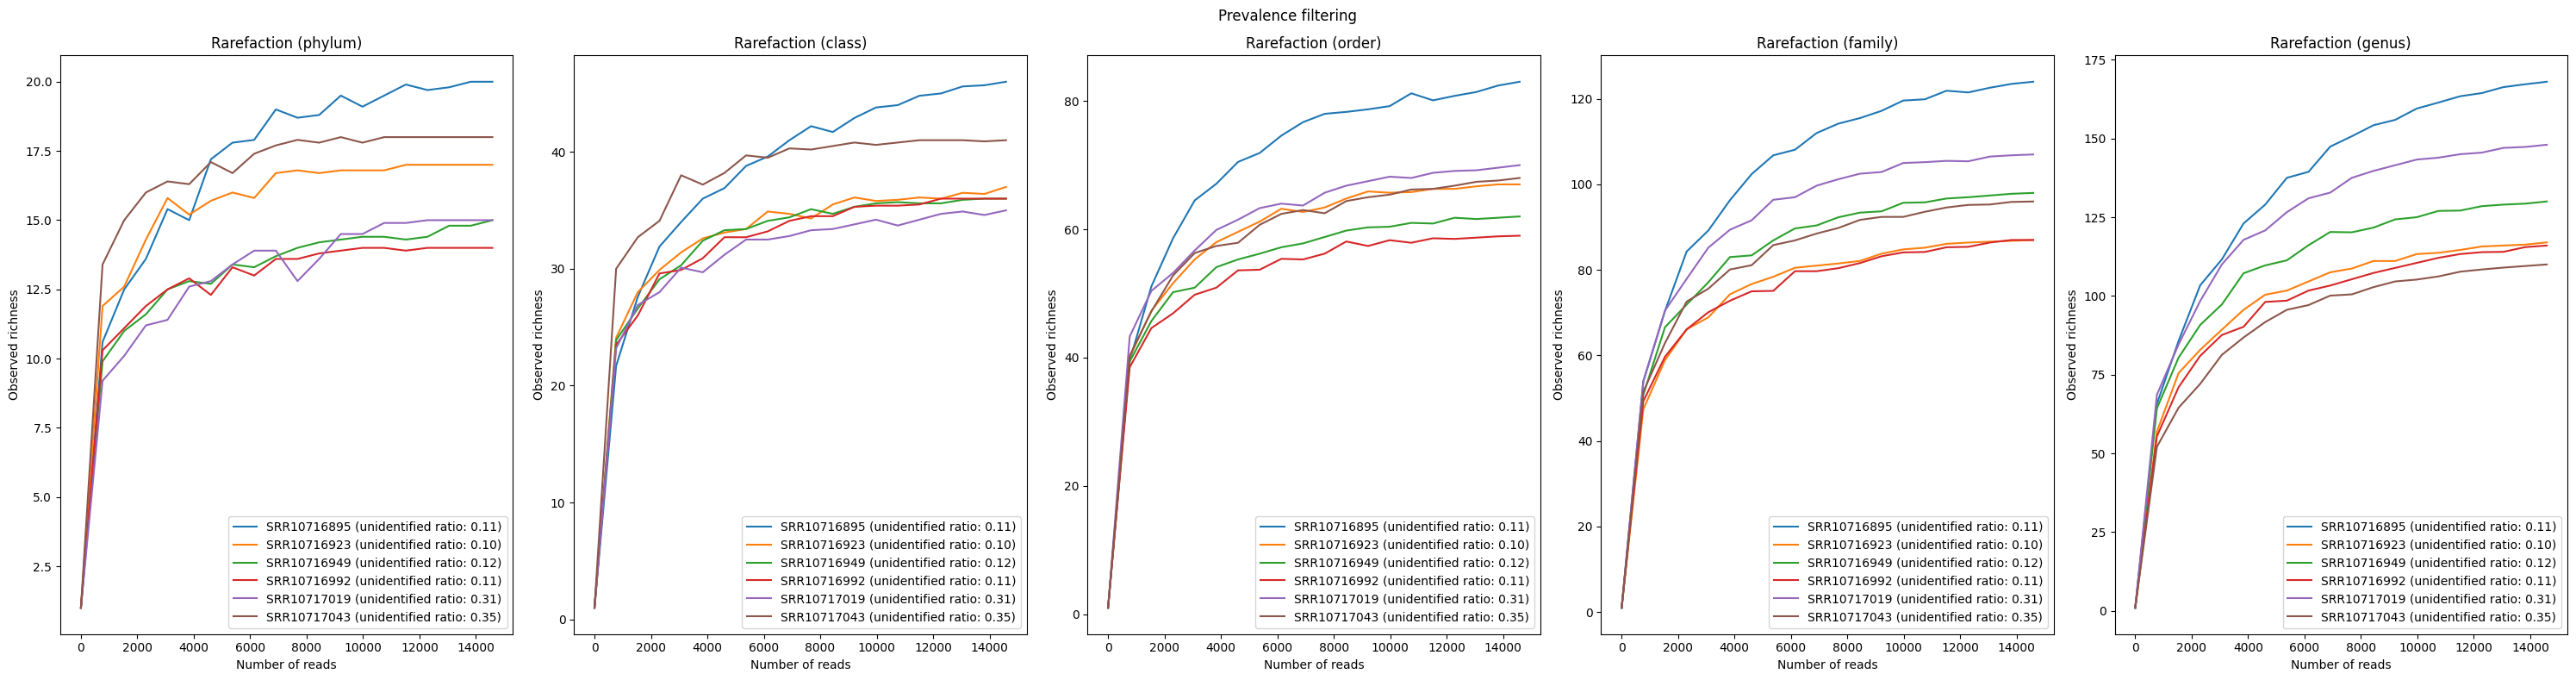

In [28]:
## PROKARYOTES ##
sample_list = samples_meta[samples_meta['sample_type']=='prok']['id'].tolist()  # this is sample list
data_list = analysis_meta[analysis_meta['relationships.sample.data.id'].isin(sample_list)].index.tolist()

# in this case it is correct, aggregate 
dropna = False   # setting for aggregation
tax_levels = ['phylum', 'class', 'order', 'family', 'genus']

# filter long_df_indexed to keep only prokaryotic samples
long_df_filt_inp = long_df_indexed[long_df_indexed.index.isin(data_list)]


min_depth = 1e9
# first pass to determine min depth
for tax in tax_levels:
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=dropna)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back

    #prevalence filtering
    df_filt_pivot = prevalence_cutoff_abund(df_filt_pivot, percent=0.01, skip_columns=0)
    df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
    min_depth = min(min_depth, df_filt_pivot.sum().min())

print("Minimum depth after rarefaction:", min_depth)

# now run again with fixed depth
fig, axes = plt.subplots(1, len(tax_levels), figsize=(6 * len(tax_levels), 8))
rarefied_tables['prok'] = {}
for ax, tax in zip(axes, tax_levels):
    long_df_filt = aggregate_by_taxonomic_level(long_df_filt_inp, level=tax, dropna=dropna)
    df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back

    #prevalence filtering
    df_filt_pivot = prevalence_cutoff_abund(
        df_filt_pivot,
        percent=0.01,
        skip_columns=0,
        verbose=False,
    )
    df_filt_pivot = rarefy_table(df_filt_pivot, depth=min_depth)
    rarefied_tables['prok'][tax] = df_filt_pivot

    # rarefaction
    print(f"Plotting rarefaction for {tax}, shape {df_filt_pivot.shape} samples")
    plot_rarefaction_mgnify(
        df_filt_pivot,
        analysis_meta,
        every_nth=20,
        ax=ax,
        title=f'Rarefaction ({tax})',
    )

plt.suptitle("Prevalence filtering")
plt.tight_layout()

# save_plot_with_metadata(
#     fig,
#     filename='rarefaction_prok.png',
#     description='Rarefaction curves per taxonomic level',
#     out_dir=OUT_FOLDER,
# )

-------------------
euk
-------------------
Taxonomic level: phylum
  Shape: (77, 133)
  Total counts per sample (min, max, mean): 17271, 17271, 17271.00
  Total counts per feature (min, max, mean): 1, 758001, 29831.73
  Number of features with non-zero counts: 77
Taxonomic level: class
  Shape: (177, 133)
  Total counts per sample (min, max, mean): 17271, 17271, 17271.00
  Total counts per feature (min, max, mean): 0, 757997, 12977.64
  Number of features with non-zero counts: 176
Taxonomic level: order
  Shape: (400, 133)
  Total counts per sample (min, max, mean): 17271, 17271, 17271.00
  Total counts per feature (min, max, mean): 0, 461314, 5742.61
  Number of features with non-zero counts: 399
Taxonomic level: family
  Shape: (621, 133)
  Total counts per sample (min, max, mean): 17271, 17271, 17271.00
  Total counts per feature (min, max, mean): 0, 433549, 3698.94
  Number of features with non-zero counts: 620
Taxonomic level: genus
  Shape: (832, 133)
  Total counts per sample (

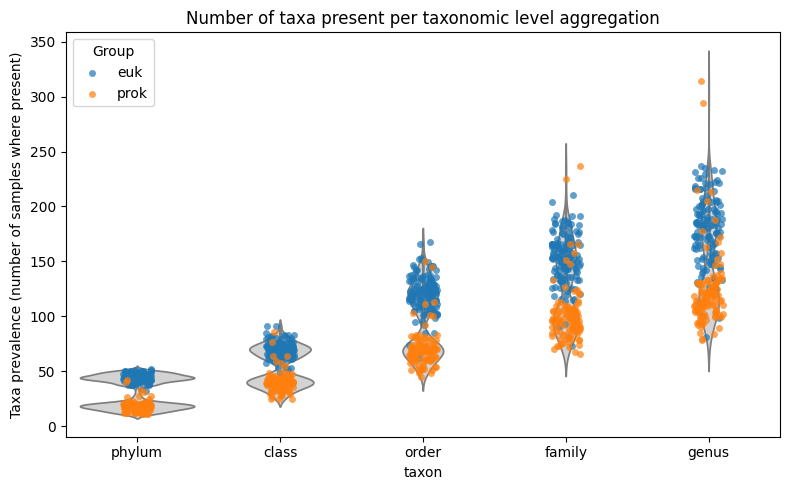

In [29]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 5))
for k, v in rarefied_tables.items():
    print('-------------------')
    print(k)
    print('-------------------')
    # Collect data for combined plotting
    combined, comb_arch, comb_bact, comb_euk = [], [], [], []
    for dic  in v.items():
        tax, table = dic
        print(f"Taxonomic level: {tax}")
        print(f"  Shape: {table.shape}")
        print(f"  Total counts per sample (min, max, mean): {table.sum(axis=0).min()}, {table.sum(axis=0).max()}, {table.sum(axis=0).mean():.2f}")
        print(f"  Total counts per feature (min, max, mean): {table.sum(axis=1).min()}, {table.sum(axis=1).max()}, {table.sum(axis=1).mean():.2f}")
        print(f"  Number of features with non-zero counts: {(table.sum(axis=1) > 0).sum()}")
        
        df = table > 0
        combined.append(df.sum().reset_index().assign(tax=tax))

        # granular
        df1 = df[df.index.str.contains('sk__Archaea')]
        df2 = df[df.index.str.contains('sk__Bacteria')]
        df3 = df[df.index.str.contains('sk__Eukaryota')]

        comb_arch.append(df1.sum().reset_index().assign(tax=tax))
        comb_bact.append(df2.sum().reset_index().assign(tax=tax))
        comb_euk.append(df3.sum().reset_index().assign(tax=tax))

    df_all = pd.concat(combined, ignore_index=True)
    df_all.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    df_arch = pd.concat(comb_arch, ignore_index=True)
    df_arch.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    df_bact = pd.concat(comb_bact, ignore_index=True)
    df_bact.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    df_euk = pd.concat(comb_euk, ignore_index=True)
    df_euk.rename(columns={0: 'counts', 'tax': 'taxon'}, inplace=True)

    # Draw violins (gray background)
    sns.violinplot(
        data=df_all,
        x="taxon", y="counts",
        inner=None, color="lightgray",
        ax=ax
    )

    # Add colored points per independent factor (region)
    # add points, but only assign a label if it's not already present to avoid duplicates
    existing_labels = ax.get_legend_handles_labels()[1]
    sns.stripplot(
        data=df_all,
        x="taxon", y="counts",
        dodge=True,
        jitter=True, alpha=0.7,
        label=(k if k not in existing_labels else None),
        ax=ax
    )

    # ensure legend has unique labels (preserve order)
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title="Group")

# Beautify
ax.set_title(f"Number of taxa present per taxonomic level aggregation")
ax.set_ylabel("Taxa prevalence (number of samples where present)")
# ax.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


# save_plot_with_metadata(
#     fig,
#     filename='violin_n_per_taxon.png',
#     description='Number of taxa per sample to compare Euk and Prok',
#     out_dir=OUT_FOLDER,
# )

In [30]:
df_arch['counts'].describe(), df_bact['counts'].describe(), df_euk['counts'].describe()

(count    535.000000
 mean       3.798131
 std        2.221869
 min        0.000000
 25%        2.000000
 50%        3.000000
 75%        6.000000
 max       11.000000
 Name: counts, dtype: float64,
 count    535.000000
 mean      66.248598
 std       42.992594
 min       10.000000
 25%       33.000000
 50%       64.000000
 75%       95.000000
 max      307.000000
 Name: counts, dtype: float64,
 count    535.000000
 mean       0.448598
 std        0.530593
 min        0.000000
 25%        0.000000
 50%        0.000000
 75%        1.000000
 max        2.000000
 Name: counts, dtype: float64)

### Rarefaction per factor (season as an example)

filtered table shape: (185, 240)
subset table shape: (103, 60)
Plotting rarefaction for phylum in Spring with 60 samples
subset table shape: (103, 33)
Plotting rarefaction for phylum in Summer with 33 samples
subset table shape: (103, 44)
Plotting rarefaction for phylum in Autumn with 44 samples
subset table shape: (103, 103)
Plotting rarefaction for phylum in Winter with 103 samples
Saved PNG: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/rarefaction_season_prevalence-10.png_20260107_114653.png
Saved PDF: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/rarefaction_season_prevalence-10.png_20260107_114653.pdf
Metadata saved: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/rarefaction_season_prevalence-10.png_20260107_114653_metadata.json
Description saved: /home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/rarefaction_season_prev

{'saved_files': {'png': '/home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/rarefaction_season_prevalence-10.png_20260107_114653.png',
  'pdf': '/home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/rarefaction_season_prevalence-10.png_20260107_114653.pdf'},
 'metadata_file': '/home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/rarefaction_season_prevalence-10.png_20260107_114653_metadata.json',
 'description_file': '/home/david-palecek/coding/emo-bon/mgnify-methods/mgnify-methods/notebooks/MGYS00006680/rarefaction_season_prevalence-10.png_20260107_114653_description.txt',
 'base_name': 'rarefaction_season_prevalence-10.png_20260107_114653'}

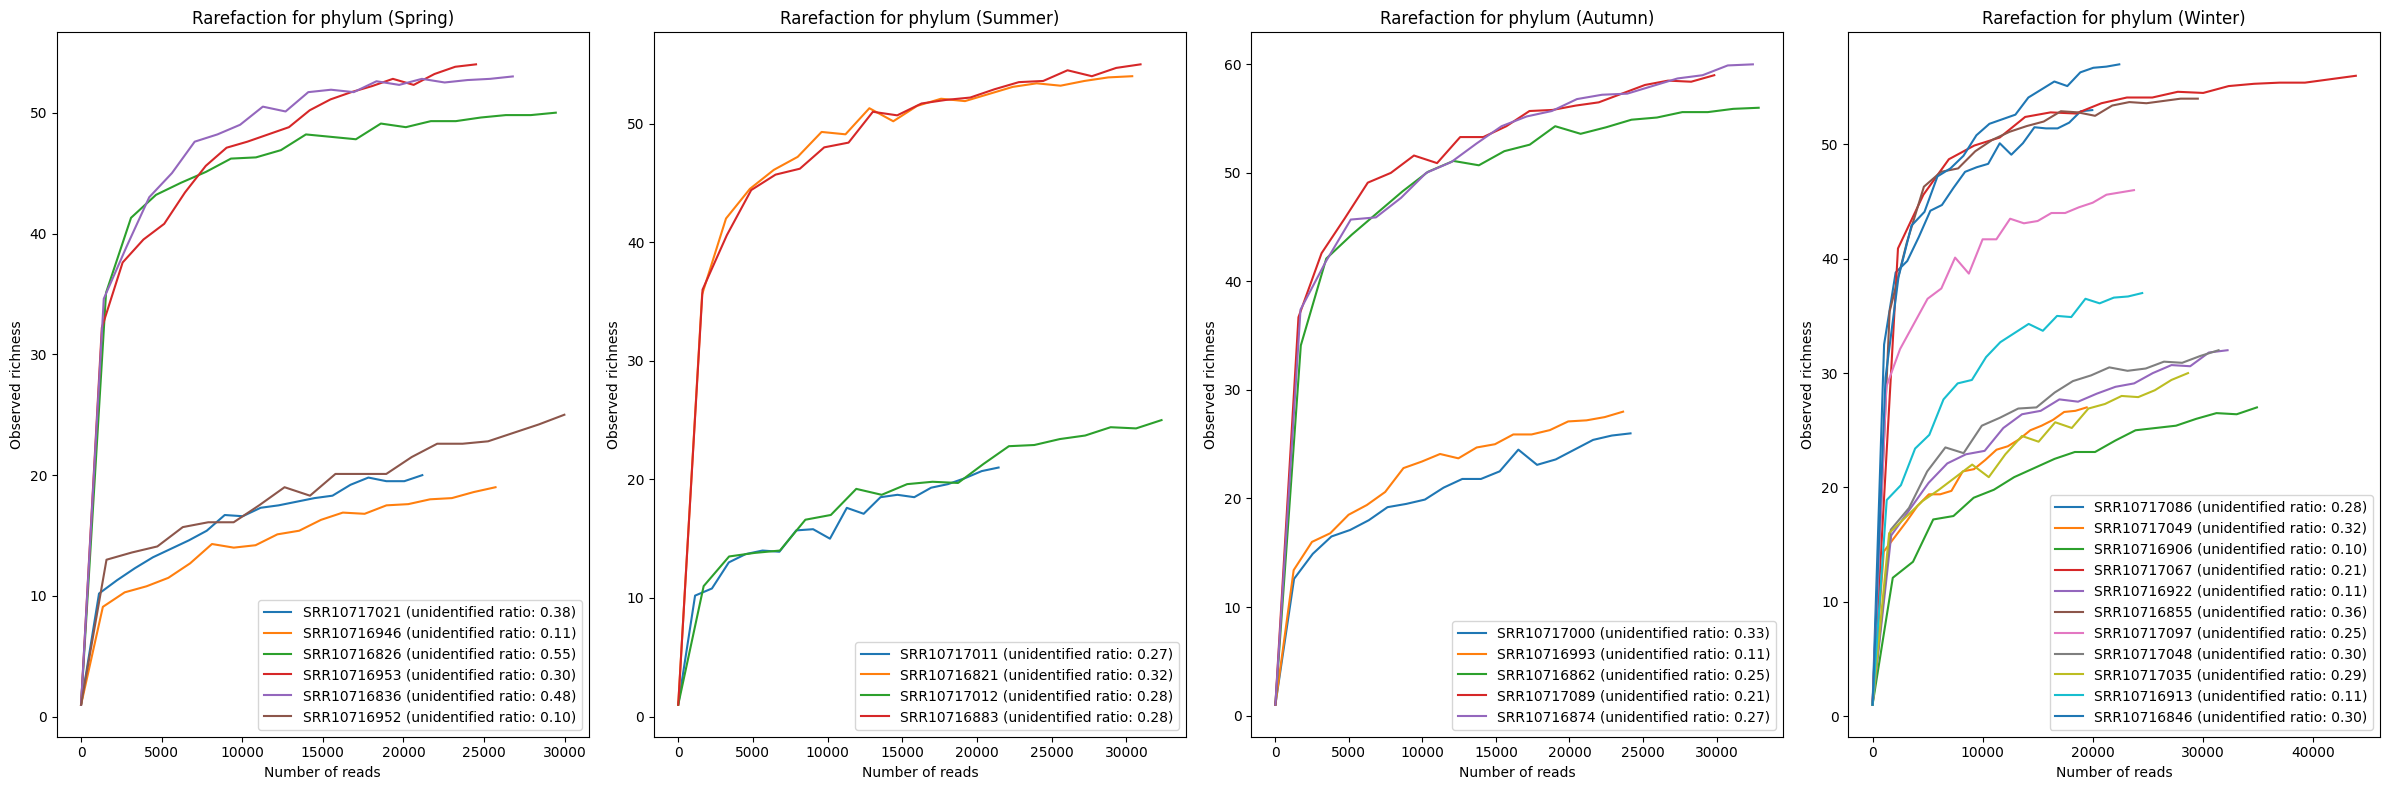

In [33]:
## Version 2, prevalence and rarefaction before the split
dropna = False   # setting for aggregation
tax_level = 'phylum'

fig, axes = plt.subplots(
    1, len(total_dict.items()),
    figsize=(6 * len(total_dict.items()), 8),
)

long_df_filt = aggregate_by_taxonomic_level(long_df_indexed, level=tax_level, dropna=dropna)
df_filt_pivot = pivot_taxonomic_data(long_df_filt)   # pivot back
print('filtered table shape:', df_filt_pivot.shape)

# preprocess, shared names in order to uncomment
df_filt_pivot = prevalence_cutoff(df_filt_pivot, percent=10, skip_columns=0)
# df_filt_pivot = rarefy_table(df_filt_pivot, depth=None)
# assert df_filt_pivot.sum().describe()['std']==0, "Rarerfaction failed, sample sums are not equal"

rarefied_tables = {}
for ax, season_dict in zip(axes, total_dict.items()):
    season, v = season_dict
    sample_subset = list(total_dict[season].keys())
    df_subset = df_filt_pivot[sample_subset]
    print('subset table shape:', df_subset.shape)

    # rarefaction
    print(f"Plotting rarefaction for {tax_level} in {season} with {len(sample_subset)} samples")
    plot_rarefaction_mgnify(
        df_subset,
        analysis_meta,
        every_nth=10,
        ax=ax,
        title=f'Rarefaction for {tax_level} ({season})',
    )
    rarefied_tables[season] = df_subset
plt.tight_layout()
# plt.savefig(os.path.join(OUT_FOLDER, 'rarefaction_season_prevalence-10.png'))


save_plot_with_metadata(
    fig,
    filename='rarefaction_season_prevalence-10.png',
    description='Rarefaction curves per season Euk and Prok mixed',
    out_dir=OUT_FOLDER,
)

Taxonomic level: Spring
  Shape: (103, 60)
  Total counts per sample (min, max, mean): 14638, 42449, 27945.17
  Total counts per feature (min, max, mean): 4, 379511, 16278.74
  Number of features with non-zero counts: 103
Taxonomic level: Summer
  Shape: (103, 33)
  Total counts per sample (min, max, mean): 17345, 51431, 29476.09
  Total counts per feature (min, max, mean): 0, 280309, 9443.80
  Number of features with non-zero counts: 101
Taxonomic level: Autumn
  Shape: (103, 44)
  Total counts per sample (min, max, mean): 19665, 39045, 30563.80
  Total counts per feature (min, max, mean): 3, 307713, 13056.38
  Number of features with non-zero counts: 103
Taxonomic level: Winter
  Shape: (103, 103)
  Total counts per sample (min, max, mean): 17884, 45379, 29386.21
  Total counts per feature (min, max, mean): 15, 673825, 29386.21
  Number of features with non-zero counts: 103


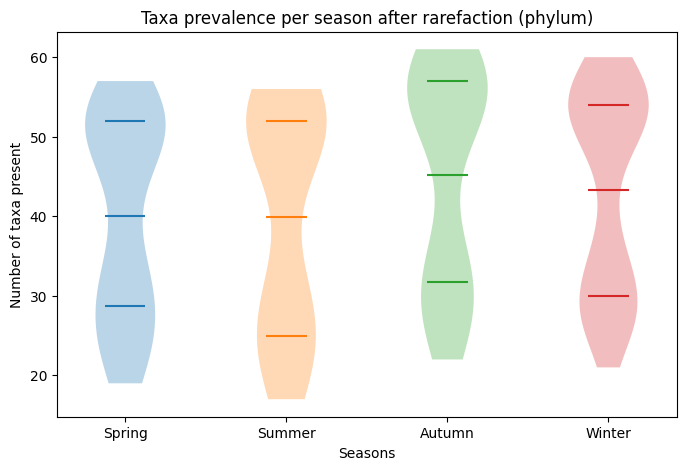

In [34]:
# Calculate stats on the rarefied tables
fig, ax = plt.subplots(figsize=(8, 5))

pos = 1
labels = []
for dic  in rarefied_tables.items():
    tax, table = dic
    print(f"Taxonomic level: {tax}")
    print(f"  Shape: {table.shape}")
    print(f"  Total counts per sample (min, max, mean): {table.sum(axis=0).min()}, {table.sum(axis=0).max()}, {table.sum(axis=0).mean():.2f}")
    print(f"  Total counts per feature (min, max, mean): {table.sum(axis=1).min()}, {table.sum(axis=1).max()}, {table.sum(axis=1).mean():.2f}")
    print(f"  Number of features with non-zero counts: {(table.sum(axis=1) > 0).sum()}")
    
    df = table > 0
    ax.violinplot(
        df.sum(), showmeans=True, positions=[pos],
        showextrema=False,
        quantiles=[[0.25, 0.75]],)
    pos += 1
    labels.append(tax)

ax.set_xticks(range(1, pos))
ax.set_xticklabels(labels)
ax.set_title(f"Taxa prevalence per season after rarefaction ({tax_level})")
ax.set_xlabel("Seasons")
ax.set_ylabel("Number of taxa present")
plt.savefig(os.path.join(OUT_FOLDER, 'taxa_number_season_prev-10.png'))
plt.show()

## EMO-BON
- here again taking simply number of reads mapped, not the total reads
- should be scaled by the total reads?

In [35]:
emobon_folder = os.path.abspath(os.path.join('../data'))
def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(emobon_folder, 'shipment_b1b2_181.csv')
    )
    return df_valid

valid_samples = get_valid_samples()

In [36]:
# High level function from the momics.utils module
full_metadata, mgf_parquet_dfs = load_and_clean(valid_samples=valid_samples)

In [37]:
# keep only taxonomy
ssu = mgf_parquet_dfs['ssu'].copy()
lsu = mgf_parquet_dfs['lsu'].copy()

del mgf_parquet_dfs

In [38]:
def process_taxonomy(df, TAXONOMY_RANKS):
    df_filt = fill_taxonomy_placeholders(df, TAXONOMY_RANKS)
    df_filt = pivot_taxonomic_data(df_filt)


# unify taxonomic information to the MGnify
    df_filt = df_filt.reset_index()
    df_filt['taxonomic_concat'] = df_filt['taxonomic_concat'].apply(clean_tax_row)

# unify column and index names
    df_filt = df_filt.set_index('ncbi_tax_id')
    df_filt = df_filt.rename(columns={
    'taxonomic_concat': '#SampleID',
})
    df_filt.rename(columns={'#SampleID': 'taxonomy'}, inplace=True)
    df_filt.set_index('taxonomy', inplace=True)
    df_filt.head()
    return df_filt

ssu_filt = process_taxonomy(ssu, TAXONOMY_RANKS)
lsu_filt = process_taxonomy(lsu, TAXONOMY_RANKS)
ssu_filt.head()

source material ID,EMOBON_AAOT_Wa_1,EMOBON_AAOT_Wa_2,EMOBON_AAOT_Wa_22,EMOBON_AAOT_Wa_26,EMOBON_AAOT_Wa_27,EMOBON_AAOT_Wa_41,EMOBON_AAOT_Wa_42,EMOBON_AAOT_Wa_46,EMOBON_AAOT_Wa_47,EMOBON_AAOT_Wa_6,EMOBON_AAOT_Wa_61,EMOBON_AAOT_Wa_62,EMOBON_AAOT_Wa_66,EMOBON_AAOT_Wa_67,EMOBON_AAOT_Wa_7,EMOBON_BPNS_So_13,EMOBON_BPNS_So_17,EMOBON_BPNS_So_18,EMOBON_BPNS_So_33,EMOBON_BPNS_So_34,EMOBON_BPNS_So_5,EMOBON_BPNS_So_6,EMOBON_BPNS_Wa_1,EMOBON_BPNS_Wa_2,EMOBON_BPNS_Wa_21,EMOBON_BPNS_Wa_22,EMOBON_BPNS_Wa_26,EMOBON_BPNS_Wa_27,EMOBON_BPNS_Wa_41,EMOBON_BPNS_Wa_42,EMOBON_BPNS_Wa_46,EMOBON_BPNS_Wa_47,EMOBON_BPNS_Wa_6,EMOBON_BPNS_Wa_61,EMOBON_BPNS_Wa_62,EMOBON_BPNS_Wa_66,EMOBON_BPNS_Wa_67,EMOBON_BPNS_Wa_7,EMOBON_EMT21_Wa_1,EMOBON_EMT21_Wa_16,EMOBON_EMT21_Wa_17,EMOBON_EMT21_Wa_2,EMOBON_EMT21_Wa_21,EMOBON_EMT21_Wa_22,EMOBON_EMT21_Wa_31,EMOBON_EMT21_Wa_32,EMOBON_EMT21_Wa_36,EMOBON_EMT21_Wa_37,EMOBON_EMT21_Wa_6,EMOBON_EMT21_Wa_7,EMOBON_ESC68N_Wa_1,EMOBON_ESC68N_Wa_11,EMOBON_ESC68N_Wa_14,EMOBON_ESC68N_Wa_2,EMOBON_ESC68N_Wa_3,EMOBON_ESC68N_Wa_4,EMOBON_HCMR-1_Wa_1,EMOBON_HCMR-1_Wa_5,EMOBON_HCMR-1_Wa_6,EMOBON_IUIEilat_Wa_1,EMOBON_IUIEilat_Wa_11,EMOBON_IUIEilat_Wa_12,EMOBON_IUIEilat_Wa_15,EMOBON_IUIEilat_Wa_16,EMOBON_IUIEilat_Wa_2,EMOBON_IUIEilat_Wa_21,EMOBON_IUIEilat_Wa_22,EMOBON_IUIEilat_Wa_25,EMOBON_IUIEilat_Wa_26,EMOBON_IUIEilat_Wa_5,EMOBON_IUIEilat_Wa_6,EMOBON_MBAL4_Wa_1,EMOBON_MBAL4_Wa_11,EMOBON_MBAL4_Wa_12,EMOBON_MBAL4_Wa_13,EMOBON_MBAL4_Wa_14,EMOBON_MBAL4_Wa_2,EMOBON_MBAL4_Wa_3,EMOBON_MBAL4_Wa_4,EMOBON_NRMCB_So_1,EMOBON_NRMCB_So_11,EMOBON_NRMCB_So_12,EMOBON_NRMCB_So_16,EMOBON_NRMCB_So_17,EMOBON_NRMCB_So_2,EMOBON_NRMCB_So_6,EMOBON_NRMCB_So_7,EMOBON_NRMCB_Wa_1,EMOBON_NRMCB_Wa_2,EMOBON_NRMCB_Wa_23,EMOBON_NRMCB_Wa_24,EMOBON_NRMCB_Wa_28,EMOBON_NRMCB_Wa_29,EMOBON_NRMCB_Wa_43,EMOBON_NRMCB_Wa_44,EMOBON_NRMCB_Wa_48,EMOBON_NRMCB_Wa_49,EMOBON_NRMCB_Wa_63,EMOBON_NRMCB_Wa_64,EMOBON_NRMCB_Wa_68,EMOBON_NRMCB_Wa_69,EMOBON_OOB_So_1,EMOBON_OOB_So_25,EMOBON_OOB_So_26,EMOBON_OSD74_Wa_1,EMOBON_OSD74_Wa_11,EMOBON_OSD74_Wa_12,EMOBON_OSD74_Wa_13,EMOBON_OSD74_Wa_14,EMOBON_OSD74_Wa_2,EMOBON_OSD74_Wa_21,EMOBON_OSD74_Wa_22,EMOBON_OSD74_Wa_23,EMOBON_OSD74_Wa_24,EMOBON_OSD74_Wa_4,EMOBON_PiEGetxo_Wa_1,EMOBON_PiEGetxo_Wa_12,EMOBON_PiEGetxo_Wa_13,EMOBON_PiEGetxo_Wa_14,EMOBON_PiEGetxo_Wa_15,EMOBON_PiEGetxo_Wa_2,EMOBON_PiEGetxo_Wa_3,EMOBON_PiEGetxo_Wa_4,EMOBON_PiEGetxo_Wa_48,EMOBON_PiEGetxo_Wa_49,EMOBON_PiEGetxo_Wa_50,EMOBON_PiEGetxo_Wa_51,EMOBON_RFormosa_So_1,EMOBON_RFormosa_So_11,EMOBON_RFormosa_So_12,EMOBON_RFormosa_So_2,EMOBON_RFormosa_So_6,EMOBON_RFormosa_So_7,EMOBON_RFormosa_Wa_1,EMOBON_RFormosa_Wa_11,EMOBON_RFormosa_Wa_12,EMOBON_RFormosa_Wa_15,EMOBON_RFormosa_Wa_16,EMOBON_RFormosa_Wa_2,EMOBON_RFormosa_Wa_21,EMOBON_RFormosa_Wa_22,EMOBON_RFormosa_Wa_25,EMOBON_RFormosa_Wa_26,EMOBON_RFormosa_Wa_5,EMOBON_RFormosa_Wa_6,EMOBON_ROSKOGO_So_1,EMOBON_ROSKOGO_So_16,EMOBON_ROSKOGO_So_17,EMOBON_ROSKOGO_So_2,EMOBON_ROSKOGO_So_21,EMOBON_ROSKOGO_So_22,EMOBON_ROSKOGO_Wa_1,EMOBON_ROSKOGO_Wa_13,EMOBON_ROSKOGO_Wa_14,EMOBON_ROSKOGO_Wa_17,EMOBON_ROSKOGO_Wa_18,EMOBON_ROSKOGO_Wa_2,EMOBON_ROSKOGO_Wa_23,EMOBON_ROSKOGO_Wa_24,EMOBON_ROSKOGO_Wa_27,EMOBON_ROSKOGO_Wa_28,EMOBON_ROSKOGO_Wa_33,EMOBON_ROSKOGO_Wa_34,EMOBON_ROSKOGO_Wa_37,EMOBON_ROSKOGO_Wa_38,EMOBON_VB_Wa_1,EMOBON_VB_Wa_137,EMOBON_VB_Wa_138,EMOBON_VB_Wa_140,EMOBON_VB_Wa_141,EMOBON_VB_Wa_2,EMOBON_VB_Wa_4,EMOBON_VB_Wa_41,EMOBON_VB_Wa_42,EMOBON_VB_Wa_43,EMOBON_VB_Wa_44,EMOBON_VB_Wa_5,EMOBON_VB_Wa_93,EMOBON_VB_Wa_94,EMOBON_VB_Wa_96,EMOBON_VB_Wa_97
taxonomy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
;sk__Bacteria,1256,1783,1920,895,536,848,461,534,304,1172,1323,2047,783,766,936,149,368,586,373,281,86,69,4046,4058,1663,2349,356,439,872,977,450,572,407,802,818,831,985,435,2107,1182,1169,1925,537,577,1642,3091,2015,1601,217,227,644,976,248,824,798,799,660,616,577,1512,1935,2011,372,404,1761,1310,1763,1012,372,417,444,144

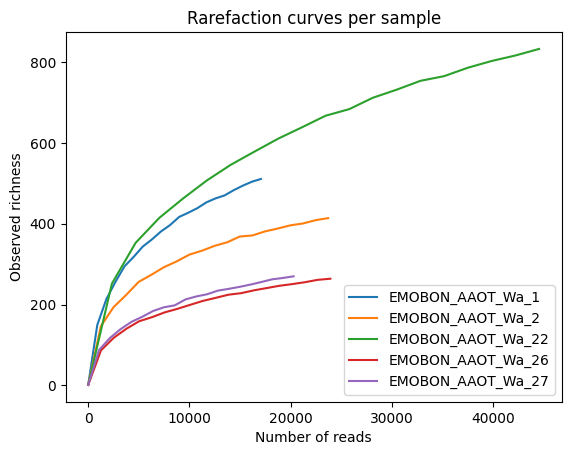

In [41]:
abund_emobon = ssu_filt.copy()

for sample in abund_emobon.columns[:5]:
    reads = np.repeat(abund_emobon.index, abund_emobon[sample].values)
    depths, richness = rarefaction_curve(reads)
    plt.plot(depths, richness, label=sample)

plt.legend()
plt.xlabel("Number of reads")
plt.ylabel("Observed richness")
plt.title("Rarefaction curves per sample")
plt.show()